In [1]:
import xlwings as xw
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Probabilistic sensitivity analysis - ICER

In [32]:
wb = xw.Book('./markov_model_PSA_ICER.xlsm')

simu_times = 1000
capi_cost, palb_cost = [], []
capi_qaly, palb_qaly = [], []
icers = []

for i in tqdm(range(simu_times)):
    wb.app.calculate()

    capi_cost.append(wb.sheets['Simulaton'].range('AK4').value)
    palb_cost.append(wb.sheets['Simulaton'].range('AJ4').value)

    capi_qaly.append(wb.sheets['Simulaton'].range('AD4').value)
    palb_qaly.append(wb.sheets['Simulaton'].range('AG4').value)

    icers.append(wb.sheets['Simulaton'].range('AM4').value)

wb.close()

100%|██████████| 1000/1000 [00:56<00:00, 17.62it/s]


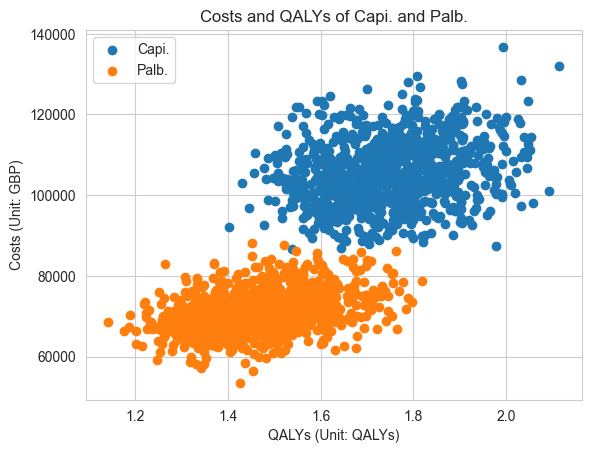

In [33]:
plt.scatter(capi_qaly, capi_cost, label='Capi.')
plt.scatter(palb_qaly, palb_cost, label='Palb.')

plt.xlabel('QALYs (Unit: QALYs)')
plt.ylabel('Costs (Unit: GBP)')
plt.title('Costs and QALYs of Capi. and Palb.')
plt.legend()

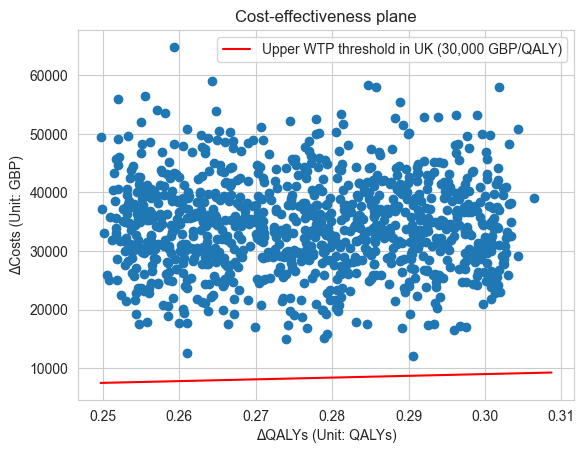

In [34]:
delta_qaly = np.array(capi_qaly) - np.array(palb_qaly)
delta_cost = np.array(capi_cost) - np.array(palb_cost)

plt.scatter(delta_qaly, delta_cost)
plt.xlabel('ΔQALYs (Unit: QALYs)')
plt.ylabel('ΔCosts (Unit: GBP)')

plt.plot(np.arange(min(delta_qaly), max(delta_qaly) * 1.01, 0.001),
         np.arange(min(delta_qaly), max(delta_qaly) * 1.01, 0.001) * 30000, color='red',
         label='Upper WTP threshold in UK (30,000 GBP/QALY)')
plt.title('Cost-effectiveness plane')
plt.legend()

In [35]:
#  icer mean and std
print('ICER mean: ', np.mean(icers))
print('ICER std: ', np.std(icers))
print('Percentage of ICER > 30,000: ', sum(np.array(icers) > 30000) / len(icers))
# 95% CI
print('95% CI: ', np.percentile(icers, [2.5, 97.5]))

ICER mean:  124409.2855453204
ICER std:  29793.410115215185
Percentage of ICER > 30,000:  1.0
95% CI:  [ 69843.54762926 186729.52243241]


C:\Users\haitao\AppData\Local\Temp\ipykernel_10120\4197792250.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(icers, bins=50)


Text(0.5, 1.0, 'Histogram of ICER')

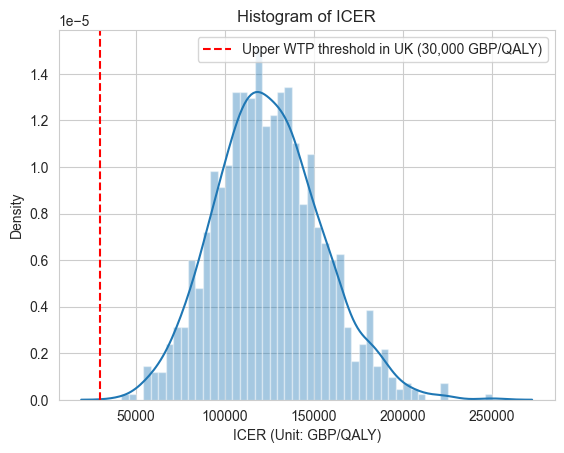

In [40]:
# icer histogram
import seaborn as sns

sns.distplot(icers, bins=50)
plt.xlabel('ICER (Unit: GBP/QALY)')
plt.axvline(x=30000, color='red', linestyle='--', label='Upper WTP threshold in UK (30,000 GBP/QALY)')
plt.legend()
plt.ylabel('Density')
plt.title('Histogram of ICER')

In [9]:
# t-test if icer < 30,000
from scipy.stats import ttest_1samp

ttest_1samp(icers, 30000)

TtestResult(statistic=107.61906417623551, pvalue=0.0, df=999)

# Probabilistic sensitivity analysis - Price ceiling of Capi.

100%|██████████| 10/10 [01:26<00:00,  8.62s/it]


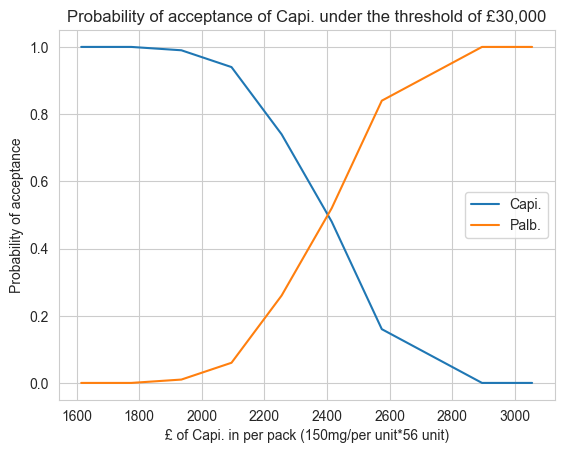

In [44]:
lwr, upr, length = 1600, 3200, 10

capi_prices = np.arange(lwr, upr, (upr - lwr) // length)

capi_acceptance_prob = []
simu_times = 100
threshold = 30000

wb = xw.Book('./markov_model_PSA_Price_Ceiling.xlsm')

for capi_price in tqdm(capi_prices):
    wb.sheets['Cost'].range('B57').value = capi_price
    ICERs = []
    for i in range(simu_times):
        wb.app.calculate()
        ICERs.append(wb.sheets['Simulaton'].range('AM4').value)
    capi_acceptance_prob.append(sum(np.array(ICERs) < threshold) / simu_times)
wb.close()

plt.plot(capi_prices + 15, capi_acceptance_prob, label='Capi.')
plt.plot(capi_prices + 15, 1 - np.array(capi_acceptance_prob), label='Palb.')
plt.xlabel('£ of Capi. in per pack (150mg/per unit*56 unit)')
plt.ylabel('Probability of acceptance')
plt.title('Probability of acceptance of Capi. under the threshold of £30,000')
plt.legend()